<img src="https://miro.medium.com/max/1200/1*NF1_eYZrV5fj0_EICLKytw.jpeg">
Transfer learning adalah suatu teknik atau metode yang memanfaatkan model yang sudah dilatih terhadap suatu dataset untuk menyelesaikan permasalahan lain yang serupa dengan cara menggunakannya sebagai starting point, memodifikasi dan mengupdate parameternya sehingga sesuai dengan dataset yang baru. Model yang kita gunakan ulang di sini adalah ResNet50. <i>FYI</i>, Pemenang <i>ImageNet Large Scale Visual Recognition Challenge</i> 2015 itu pake model ResNet yang jumlah <i>hidden layer</i>'nya 150'an.

### 1. <i>Import libraries</i>

In [49]:
import torch
import numpy as np
from os import listdir
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, precision_score, f1_score, recall_score
from torchvision import datasets, transforms, models

<b>torch</b> agar si mesin bisa <i>learning</i><br>
<b>np</b> untuk melakukan operasi matriks<br>
<b>listdir</b> untuk mengetahui isi direktori(dalam hal ini adalah kelas yang akan diprediksi)<br>
<b>plt</b> untuk visualisasi data<br>
<b>classification_report</b> untuk evaluasi kinerja<br>
<b>datasets, transforms</b> & <b>models</b> untuk mengolah dataset, mentransform citra, dan memuat model(untuk <i>transfer learning</i>)

### 2. Lihat isi direktori pada direktori <i>dataset</i>

In [50]:
listdir("MRI Images for Brain Tumor Detection/")

['Uninfected', 'Parasitized']

Jadi ada dua <i>folder</i><br>
<i>folder <b>no</b></i> yang menampung citra otak yang ndak ada tumornya<br>
sama <i>folder <b>yes</b></i> yang menampung citra otak yang ada tumornya

### 3. Pilih perangkat untuk melatih si mesin

In [51]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

Jelas pake GPU dong :)<br>
<i>FYI</i>, GPU yang saya pake itu Nvidia GeForce 940MX<br>
<img src="https://scontent-sjc3-1.cdninstagram.com/vp/8047e80885e3137c17af74524d394a40/5D8610CD/t51.2885-15/sh0.08/e35/s640x640/61996480_135392614313226_1890865115003346728_n.jpg?_nc_ht=scontent-sjc3-1.cdninstagram.com" height=100>

### 4. Lakukan sedikit persiapan(praproses, bagi <i>dataset</i>, & lihat datanya)

In [52]:
train_transforms = transforms.Compose([transforms.Resize((120, 120)),   # UKURAN CITRANYA JADI 120X120 PIKSEL
                                       transforms.ColorJitter(0.05),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomVerticalFlip(),
                                       transforms.RandomRotation(20),
                                       transforms.ToTensor(), 
                                       transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

#### 4.1 Bagi <i>dataset</i>

In [53]:
image_dir = "MRI Images for Brain Tumor Detection/"
train_set = datasets.ImageFolder(image_dir, transform=train_transforms)

In [54]:
test_size = 0.3   # JUMLAH DATA UJI BISA DISESUAIKAN

num_train = len(train_set)
indices = list(range(num_train))
np.random.shuffle(indices)

test_split = int(np.floor((test_size) * num_train))
test_index, train_index = indices[:test_split - 1], indices[test_split - 1:]

train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_index)
test_sampler = torch.utils.data.sampler.SubsetRandomSampler(test_index)

train_loader = torch.utils.data.DataLoader(train_set, sampler=train_sampler, batch_size=104)
test_loader = torch.utils.data.DataLoader(train_set, sampler=test_sampler, batch_size=58)
print("Images in Test set: {}\nImages in Train set: {}".format(len(test_index), len(train_index)))

Images in Test set: 74
Images in Train set: 179


Oke jadi data buat latihannya ada 179 citra<br>
Sedangkan data ujinya ada 74 citra

In [55]:
classes=['Ada tumor','Tidak ada tumor']

#### 4.2 Visualisasikan datanya

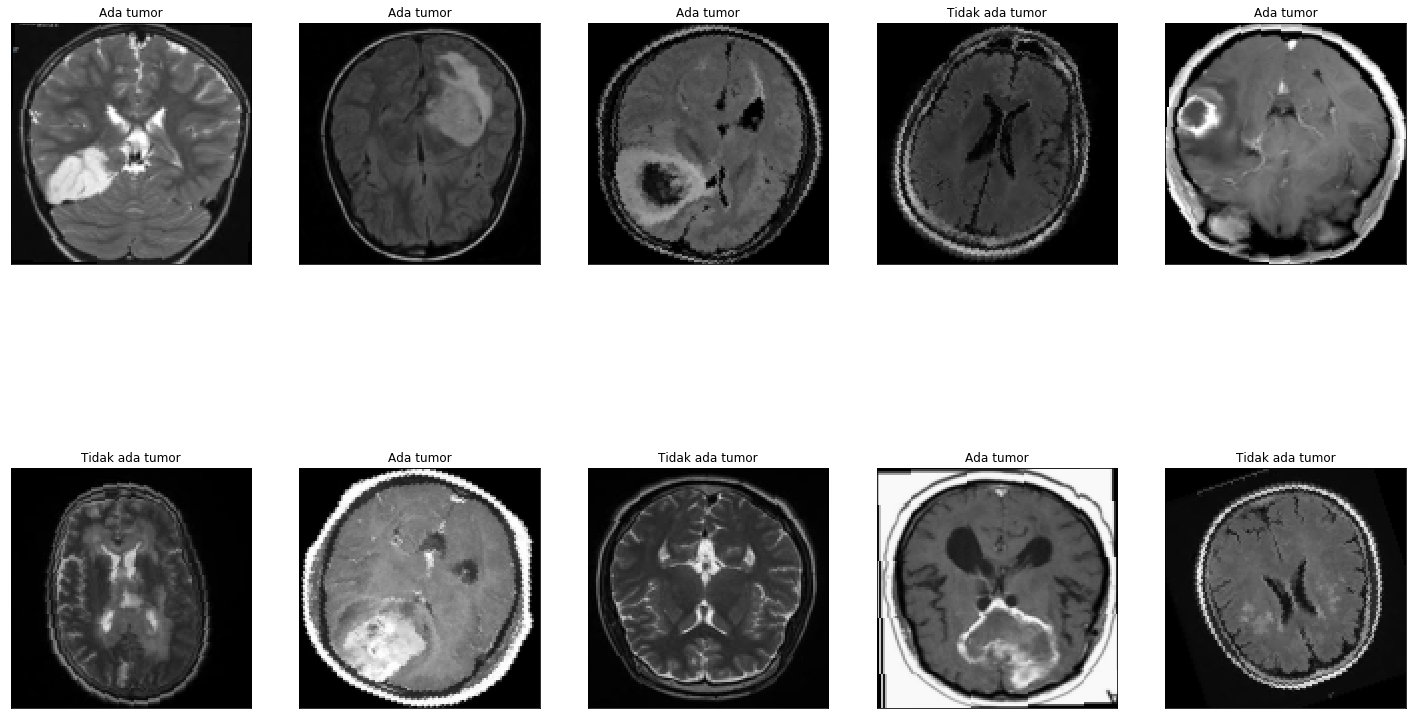

In [56]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
images, labels = next(iter(train_loader))

fig = plt.figure(figsize=(25, 15))

for i in range(10):
    ax = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[], title=classes[labels[i]])
    imshow(images[i])
plt.show()

Nah udah kebanyangkan datanya kayak gimana?<br>
Jadi kita ini sekarang lagi bikin sistem deteksi tumor otak ehehe<br>
<i>FYI</i>, ini program kalau dijual murah ke rumah sakit <i>in syaa' Allah</i> laku :v

### 5. Kita pake <i>RESidual NETwork</i>

Baca lebih lanjut di sini https://arxiv.org/abs/1512.03385

In [57]:
import torch.nn as nn
import torch.nn.functional as F

class MosquitoNet(nn.Module):
    
    def __init__(self):
        super(MosquitoNet, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
            
        self.fc1 = nn.Linear(64*15*15, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 2)
        self.drop = nn.Dropout2d(0.2)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)    # flatten out a input for Dense Layer
        out = self.fc1(out)
        out = F.relu(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = F.relu(out)
        out = self.drop(out)
        out = self.fc3(out)
        
        return out

In [72]:
# YANG LAIN BISA DILIHAT DI SINI => pytorch.org/docs/stable/torchvision/models.html
model = models.squeezenet1_1(pretrained=True)

# PARAMETER AWAL PADA MODEL NDAK PERLU DIPROPAGASI BALIK

for param in model.parameters():
    param.requires_grad = False
    
classifier = torch.nn.Sequential(torch.nn.Linear(1024, 512),   # DAPAT DISESUAIKAN
                                 torch.nn.ReLU(),              # FUNGSI AKTIVASINYA RECTIFIED LINEAR UNIT
                                 torch.nn.Dropout(0.2),        # AGAR TIDAK OVERFITTING
                                 torch.nn.Linear(512, 2),      # DAPAT DISESUAIKAN - 2 ITU MAKSUDNYA JUMLAH KELAS YANG MAU DIPREDIKSI(YES/NO)
                                 torch.nn.LogSoftmax(dim=1))

model.fc = classifier
error = torch.nn.NLLLoss()   # YANG LAIN BISA DILIHAT DI SINI => pytorch.org/docs/stable/nn.html#loss-functions

fc_parameters = model.fc.parameters()

for param in fc_parameters:
    param.requires_grad = False
    
# YANG LAIN BISA DILIHAT DI SINI => pytorch.org/docs/stable/optim.html#algorithms
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.003)
model.to(device);

<img src="https://pics.me.me/when-someone-says-they-got-a-phd-in-machine-learning-34216666.png">

In [73]:
# KITA LIHAT ISI DARI RESNET 50
model

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace)
    )
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0

NAH!<br>
<img src="https://i.imgur.com/gRi15b5.jpg">

### 6. Latih ulang model ResNet50

In [74]:
num_epochs = 15   # DAPAT DISESUAIKAN
batch_size = 100

for epoch in range(num_epochs):
    train_loss = 0.
    model.train()
    
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        train = images.view(-1, 3, 120, 120)
        outputs = model(train)
        
        optimizer.zero_grad()
        loss = error(outputs, labels)
        loss.backward()    # BUAT PROPAGASI BALIK - MUDAH SEKALI :V
        optimizer.step()
        
        train_loss += loss.item() * batch_size
     
    print("Epoch: {}, Loss: {:.4f}".format(epoch + 1, train_loss / len(train_loader.dataset)))

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

### 7. Evaluasi kinerja

In [24]:
actual = []
predict = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        actual.extend(labels.data.tolist())

        test = images.view(-1, 3, 120, 120)
        outputs = model(test)
        predicted = torch.max(outputs, 1)[1]
        predict.extend(predicted.data.tolist())

In [25]:
print(classification_report(actual,predict))

              precision    recall  f1-score   support

           0       0.68      1.00      0.81        42
           1       1.00      0.38      0.55        32

    accuracy                           0.73        74
   macro avg       0.84      0.69      0.68        74
weighted avg       0.82      0.73      0.69        74



In [18]:
confusion_matrix(actual,predict)

array([[41,  1],
       [14, 18]])

In [19]:
recall_score(actual,predict)

0.5625

In [20]:
precision_score(actual,predict)

0.9473684210526315

In [21]:
f1_score(actual,predict)

0.7058823529411765

Alhamdulillah lancar<br>
Nah jadi cukup segini aja<br>
Kode sumber ini diolah dari berbagai macam sumber yang ada di internet<br>
Kalo masih belum paham ndak papa ehehe<br>
<i>Template(File)</i> ini bisa buat dipake ulang tinggal disesuaikan saja dengan model yang hendak digunakan

<img src="https://i.imgur.com/8p1md4j.jpg">

In [62]:
import torch.utils.data as data_utils
import torchvision.transforms as transforms
import torch
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns
from torch import optim
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
%matplotlib inline

In [63]:
train_transforms = transforms.Compose([transforms.Resize((120, 120)),   # UKURAN CITRANYA JADI 120X120 PIKSEL
                                       transforms.ColorJitter(0.05),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomVerticalFlip(),
                                       transforms.RandomRotation(20),
                                       transforms.ToTensor(), 
                                       transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

In [64]:
img_dir="MRI Images for Brain Tumor Detection/"
train_data = datasets.ImageFolder(img_dir,transform=train_transforms)

In [65]:


# number of subprocesses to use for data loading
num_workers = 0
# percentage of training set to use as validation
valid_size = 0.1

test_size = 0.2

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
valid_split = int(np.floor((valid_size) * num_train))
test_split = int(np.floor((valid_size+test_size) * num_train))
valid_idx, test_idx, train_idx = indices[:valid_split], indices[valid_split:test_split], indices[test_split:]

print(f'val_index: {len(valid_idx)},test_index: {len(test_idx)},train_index: {len(train_idx)}')

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
test_sampler = SubsetRandomSampler(test_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=101,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=33, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(train_data, batch_size=106,
    sampler=test_sampler, num_workers=num_workers)

val_index: 25,test_index: 50,train_index: 178


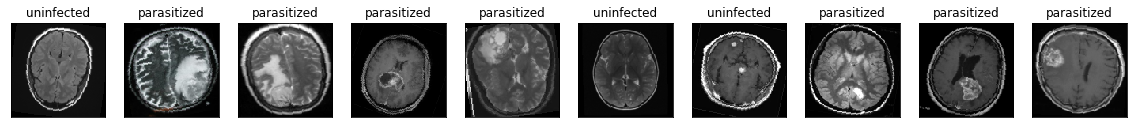

In [66]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))
    
classes=['parasitized','uninfected']

dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 20))
# display 20 images
for idx in np.arange(10):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

In [ ]:
model = models.resnet50(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Linear(2048, 2, bias=True)

fc_parameters = model.fc.parameters()

for param in fc_parameters:
    param.requires_grad = True
    
model

In [67]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [68]:
if torch.cuda.is_available():
    model = model.cuda()

In [26]:
n_epochs = 20

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    #if valid_loss <= valid_loss_min:
    #    print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
    #    valid_loss_min,
    #    valid_loss))
        #torch.save(model.state_dict(), 'model.pt')
    #    valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 0.172670 	Validation Loss: 0.014080
Epoch: 2 	Training Loss: 0.188759 	Validation Loss: 0.025897
Epoch: 3 	Training Loss: 0.144106 	Validation Loss: 0.012656
Epoch: 4 	Training Loss: 0.145723 	Validation Loss: 0.022521
Epoch: 5 	Training Loss: 0.123955 	Validation Loss: 0.030709
Epoch: 6 	Training Loss: 0.135687 	Validation Loss: 0.013320
Epoch: 7 	Training Loss: 0.164921 	Validation Loss: 0.013777
Epoch: 8 	Training Loss: 0.135354 	Validation Loss: 0.009854
Epoch: 9 	Training Loss: 0.115105 	Validation Loss: 0.015819
Epoch: 10 	Training Loss: 0.112767 	Validation Loss: 0.016474
Epoch: 11 	Training Loss: 0.140857 	Validation Loss: 0.016145
Epoch: 12 	Training Loss: 0.116815 	Validation Loss: 0.017202
Epoch: 13 	Training Loss: 0.120845 	Validation Loss: 0.013598
Epoch: 14 	Training Loss: 0.129401 	Validation Loss: 0.019458
Epoch: 15 	Training Loss: 0.107985 	Validation Loss: 0.015804
Epoch: 16 	Training Loss: 0.104303 	Validation Loss: 0.012936
Epoch: 17 	Traini

In [27]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))

model.eval()
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if torch.cuda.is_available():
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class

    
    for i in range(50):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
        
    # average test loss
    test_loss = test_loss/len(test_loader.dataset)
    print('Test Loss: {:.6f}\n'.format(test_loss))

    for i in range(2):
        if class_total[i] > 0:
            print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
                classes[i], 100 * class_correct[i] / class_total[i],
                np.sum(class_correct[i]), np.sum(class_total[i])))
        else:
            print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

    print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
        100. * np.sum(class_correct) / np.sum(class_total),
        np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.038971

Test Accuracy of parasitized: 93% (27/29)
Test Accuracy of uninfected: 95% (20/21)

Test Accuracy (Overall): 94% (47/50)


In [28]:
class_correct

[27.0, 20.0]

In [29]:
class_total

[29.0, 21.0]

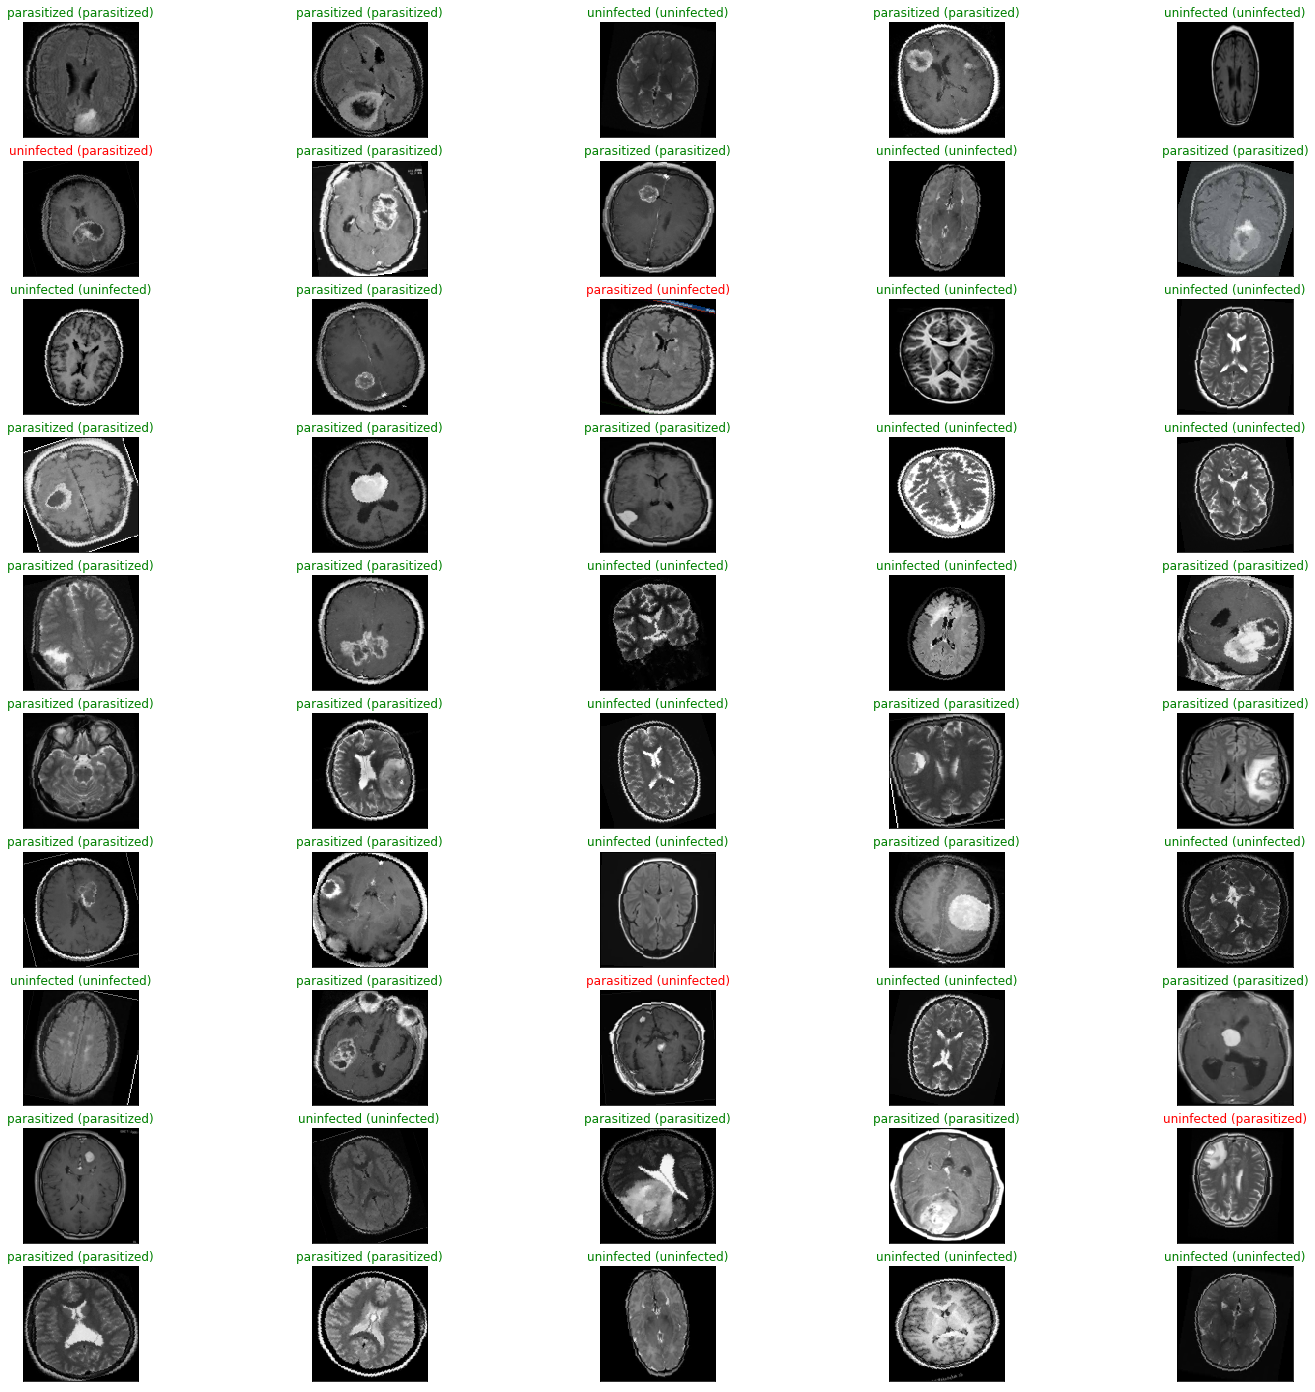

In [30]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if torch.cuda.is_available():
    images = images.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 25))
for idx in np.arange(50):
    ax = fig.add_subplot(10, 5, idx+1, xticks=[], yticks=[])
    imshow(images.cpu()[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))